# Fishing-Score Sensivity to AIS Degradation

We examine the sensitivity of current best model (Gear-Specific, Multi-Window 
Logistic Model with is-daylight) with respect to degredation of the AIS
data. 

We train as normal, then progessively randomly dropout more and more of
the training data and see how that effects the resulting predicted
results. We restrict ourselves to looking at a subset of the initial
AIS points where there were 100-200 AIS points in the previous 24 hour period.
This allows us to to see the effects of dropout at consistent point
bins.

Before this note book is run, the dropped out datasets must be
created by running:

```
python scripts/add_all_features.py --keep 0.8 
python scripts/add_all_features.py --keep 0.6 
python scripts/add_all_features.py --keep 0.4 
python scripts/add_all_features.py --keep 0.2 
python scripts/add_all_features.py --keep 0.1 
python scripts/add_all_features.py --keep 0.05
python scripts/add_all_features.py --keep 0.02
python scripts/add_all_features.py --keep 0.01

```

Step 1 – import required modules and define some helper functions:

In [1]:
%matplotlib inline
from __future__ import print_function, division
import sys
sys.path.append('..')
from vessel_scoring import data, utils
from vessel_scoring.models import train_model_on_data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
from vessel_scoring.logistic_model import LogisticModel

def make_model(seed=4321):
    return LogisticModel(colspec=dict(
        windows=[1800, 3600, 10800, 21600, 43200, 86400],
        measures=['measure_daylight', 'measure_speed']), order=6, random_state=seed)


In [3]:
def load_data(suffix='', seed=4321, even_split=True):
    """Load train / test data
    
    This loads the datasets as they are normally used in training / testing.
    """
    # Data supplied by Kristina
    _, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
            '../datasets/kristina_longliner.measures{}.npz'.format(suffix), 
             even_split=even_split, seed=seed)
    _, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
            '../datasets/kristina_trawl.measures{}.npz'.format(suffix), 
             even_split=even_split, seed=seed)
    _, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
            '../datasets/kristina_ps.measures{}.npz'.format(suffix), 
            even_split=even_split, seed=seed)

    # Slow transits (used to train models to avoid classifying slow transits as fishing)
    TRANSIT_WEIGHT = 10
    x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                        '../datasets/slow-transits.measures{}.npz'.format(suffix), 
                         even_split=False, seed=seed)
    xtrain_tran = utils.clone_subset(xtrain_tran, test_lline.dtype)
    xcross_tran = utils.clone_subset(xcross_tran, test_lline.dtype)
    xtest_tran = utils.clone_subset(xtest_tran, test_lline.dtype)
    train_tran = np.concatenate([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

    train = {'longliner': np.concatenate([train_lline, valid_lline, train_tran]), 
                'trawler': np.concatenate([train_trawl, valid_trawl, train_tran]),
                'purse_seine': np.concatenate([train_pseine, valid_pseine, train_tran])}
    
    test = {'longliner': test_lline, 
            'trawler': test_trawl, 
            'purse_seine': test_pseine}
    
    return train, test

In [4]:
def _load_test_data(path, mmsi, even_split=True):
    test_data, _, _, _ = data.load_dataset_by_vessel(path, even_split=even_split)
    
    mask = np.zeros(test_data.shape, dtype='bool')
    for m in mmsi:
        mask |= (test_data['mmsi'] == m)
                
    return test_data[mask]

def load_test_data(suffix, mmsi_map, even_split=True):
    # Data supplied by Kristina
    test_lline = _load_test_data(
        '../datasets/kristina_longliner.measures{}.npz'.format(suffix), 
                             mmsi_map['longliner'], even_split=even_split)
    test_trawl = _load_test_data(
        '../datasets/kristina_trawl.measures{}.npz'.format(suffix), 
                            mmsi_map['trawler'], even_split=even_split)
    test_pseine = _load_test_data(
        '../datasets/kristina_ps.measures{}.npz'.format(suffix), 
                            mmsi_map['purse_seine'], even_split=even_split)
    
    return {'longliner': test_lline, 
            'trawler': test_trawl, 
            'purse_seine': test_pseine}

In [5]:

def _fishing_hours_per_mmsi(data, preds, mask, max_gap):
    # assumes single vessel (mmmsi)
    indices = np.argsort(data['timestamp'])
    data = data[indices]
    preds = preds[indices]
    thresholded = (preds > 0.5)
    dt = (data['timestamp'][1:] - data['timestamp'][:-1]) / (60 * 60)
    dt = np.minimum(dt, max_gap)
    avg_pred = 0.5 * (preds[1:] + preds[:-1])
    avg_thresh = 0.5 * (thresholded[1:] + thresholded[:-1])
    avg_nominal = 0.5 * (data['classification'][1:] + data['classification'][:-1])
    if mask is not None:
        dt *= (mask[1:] + mask[:-1]) / 2.0
    return (avg_pred * dt).sum(), (avg_thresh * dt).sum(), (avg_nominal * dt).sum()

def fishing_hours(data, preds, mask=None, max_gap=24):
    mmsi = set(data['mmsi'])
    pred_hours = thresh_hours = nominal_hours = 0
    for m in mmsi:
        mmsi_mask = (data['mmsi'] == m)
        p_hours, t_hours, n_hours = _fishing_hours_per_mmsi(data[mmsi_mask], 
                                                            preds[mmsi_mask],
                                                            mask=mask,
                                                            max_gap=max_gap)
        pred_hours += p_hours
        thresh_hours += t_hours
        nominal_hours += n_hours
    return pred_hours, thresh_hours, nominal_hours

To create the features:

```
python scripts/add_all_features.py --keep 0.8 
python scripts/add_all_features.py --keep 0.6 
python scripts/add_all_features.py --keep 0.4 
python scripts/add_all_features.py --keep 0.2 
python scripts/add_all_features.py --keep 0.1 
python scripts/add_all_features.py --keep 0.05
python scripts/add_all_features.py --keep 0.02
python scripts/add_all_features.py --keep 0.01

```

# Compute Statistics for Various Dropouts

We look at the effec on the points that originally had 100-200 PPD at various dropouts.
This lets us state that the approximate points per day of the dropped out points is
$100\alpha - 200\alpha$ where $\alpha$ is the fraction of the points that are not
dropped.


In [10]:
EVEN_SPLIT = True

keep_probs = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.02, 0.01]

# Load the undropped out data. `train_data` is used for training
# while test_data is used for the \alpha = 1 case.
train_data, test_data = load_data(even_split=EVEN_SPLIT)

mmsi_map = {x : set(test_data[x]['mmsi']) for x in ['purse_seine', 'trawler', 'longliner']}

# Load dropped out data for all alphas in the `keeps_probs` other
# than 1.
drop_test = {1: load_test_data('', mmsi_map)}
for kp in keep_probs[1:]:
    suffix = '-{}'.format(str(kp).replace('.', ''))
    drop_test[kp] = load_test_data(suffix=suffix, mmsi_map=mmsi_map, even_split=EVEN_SPLIT)

predictions = {}

for gear in ['purse_seine', 'trawler', 'longliner']:
    mdl = make_model()
    train_model_on_data(mdl, train_data[gear])
    
    # find points in undropped test_data where there are between 100 and 200 ppd
    full_point_set = drop_test[1][gear]
    fps_counts = full_point_set['measure_count_86400']
    test_points = full_point_set[(fps_counts >= 100) & (fps_counts <= 200)]
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
                
    predictions[gear] = []
    for kp in keep_probs:  

        raw_td = drop_test[kp][gear]
        # Make a map of (mmsi, timestamp) -> location in dropped out data 
        tdmap = {(x['mmsi'], x['timestamp']) : i for (i, x) in enumerate(raw_td)}
        tdlist = []
        for x in test_points:
            key = (x['mmsi'], x['timestamp'])
            if key in tdmap:
                tdlist.append(raw_td[tdmap[key]])
        td = np.array(tdlist)
            
        raw = mdl.predict_proba(td)[:,1]
        predictions[gear].append((kp, td, raw, (raw > 0.5), td['classification'] > 0.5))

    lines = ["|PPD-low|PPD-high|Recall|Precision|F1-Score|ROC-AUC|",
             "|-----|----|------|---------|--------|-------|"]
    for kp, td, raw, pred, actual in predictions[gear]:
        fpr, tpr, thresholds = metrics.roc_curve(actual, raw)
        auc = metrics.auc(fpr, tpr)
        lines.append("|{}|{}|{:.2f}|{:.2f}|{:.2f}|{:.2f}|".format(int(100 * kp), int(200 * kp),
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred),
                                            auc))

    display(Markdown('\n'.join(lines)))    
    display(HTML("<hr/>"))

Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all


|PPD-low|PPD-high|Recall|Precision|F1-Score|ROC-AUC|
|-----|----|------|---------|--------|-------|
|100|200|0.86|0.30|0.44|0.94|
|80|160|0.84|0.29|0.43|0.94|
|60|120|0.82|0.29|0.42|0.93|
|40|80|0.79|0.28|0.41|0.92|
|20|40|0.72|0.24|0.37|0.91|
|10|20|0.73|0.26|0.38|0.91|
|5|10|0.66|0.28|0.39|0.90|
|2|4|0.50|0.24|0.32|0.88|
|1|2|0.52|0.28|0.37|0.93|

|PPD-low|PPD-high|Recall|Precision|F1-Score|ROC-AUC|
|-----|----|------|---------|--------|-------|
|100|200|0.89|0.96|0.92|0.96|
|80|160|0.88|0.96|0.92|0.96|
|60|120|0.88|0.96|0.92|0.96|
|40|80|0.88|0.96|0.92|0.96|
|20|40|0.87|0.96|0.91|0.96|
|10|20|0.86|0.96|0.91|0.96|
|5|10|0.78|0.97|0.86|0.95|
|2|4|0.60|0.97|0.74|0.90|
|1|2|0.42|0.94|0.58|0.86|

|PPD-low|PPD-high|Recall|Precision|F1-Score|ROC-AUC|
|-----|----|------|---------|--------|-------|
|100|200|0.81|0.94|0.87|0.85|
|80|160|0.81|0.94|0.87|0.85|
|60|120|0.80|0.93|0.86|0.84|
|40|80|0.79|0.94|0.86|0.84|
|20|40|0.77|0.94|0.85|0.83|
|10|20|0.67|0.95|0.78|0.82|
|5|10|0.55|0.95|0.69|0.76|
|2|4|0.34|0.96|0.50|0.69|
|1|2|0.20|0.95|0.33|0.62|

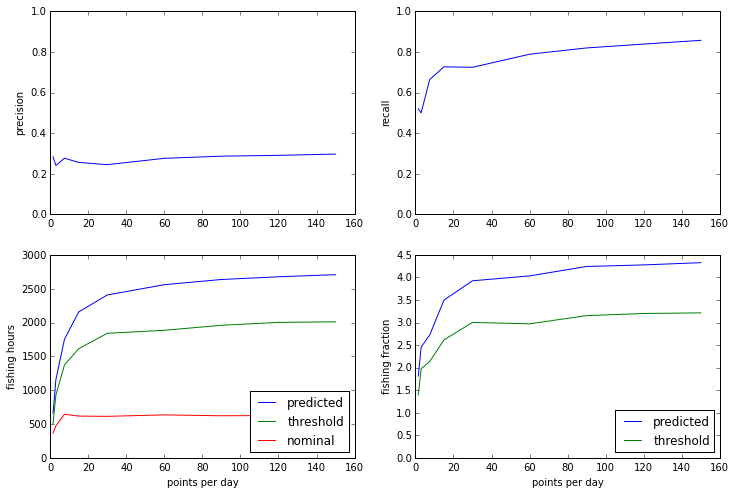

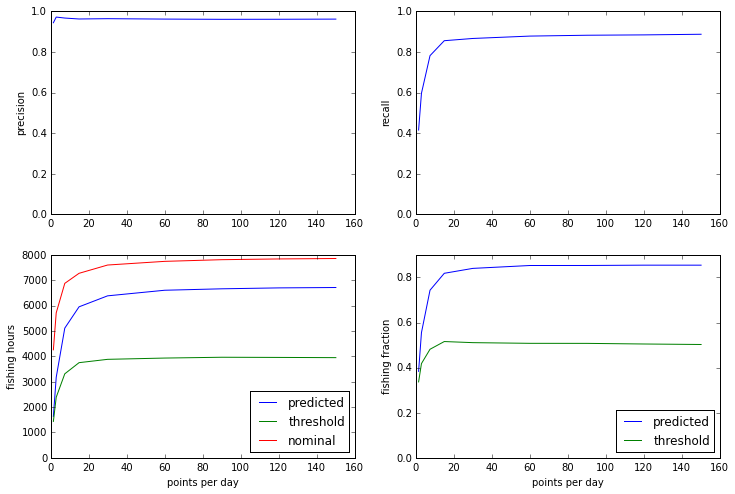

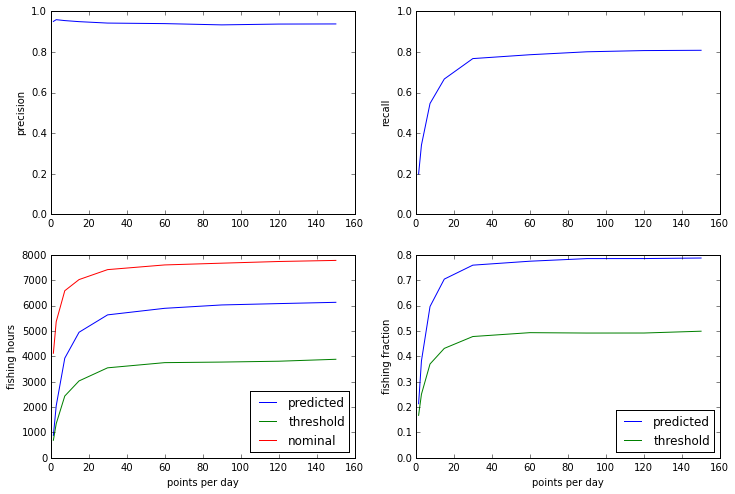

In [7]:
for gear in ['purse_seine', 'trawler', 'longliner']:

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
    
    ppd = []
    prec = []
    recall = []
    pred_hours = []
    thresh_hours = []
    nom_hours = []
    
    for kp, td, raw, pred, actual in predictions[gear]:
        ppd.append(150 * kp)
        recall.append(metrics.recall_score(actual, pred))
        prec.append(metrics.precision_score(actual, pred))
        pred, thresh, nom = fishing_hours(td, raw)
        pred_hours.append(pred)
        thresh_hours.append(thresh)
        nom_hours.append(nom)

    ax1.plot(ppd, prec)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("precision")

    ax2.plot(ppd, recall)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("recall")
    
    ax3.plot(ppd, pred_hours, label="predicted")
    ax3.plot(ppd, thresh_hours, label="threshold")
    ax3.plot(ppd, nom_hours, label="nominal")
    ax3.set_xlabel("points per day")
    ax3.set_ylabel("fishing hours")
    ax3.set_ylim(0, None)
    ax3.legend(loc=4)

    ax4.plot(ppd, np.array(pred_hours, dtype=float) / nom_hours, label="predicted")
    ax4.plot(ppd, np.array(thresh_hours, dtype=float) / nom_hours, label="threshold")
    ax4.set_xlabel("points per day")
    ax4.set_ylabel("fishing fraction")
    ax4.set_ylim(0, None)
    ax4.legend(loc=4)

    plt.show()

# Check Against Binned the Original Data

As a consistency check, we repeat the above exercise, but instead of starting with
100-200 PPB and downsampling, we chose the same PPD bins in the original data and
repeat the above plots.

As you can see in the plots below, precision, recall and fishing fraction are consistent
with the analysis above except where we run out of points. Fishing hours is not, but
that is expected since we are looking at different parts of the data set and there's
no particular reason for the fishing hours to be the same.

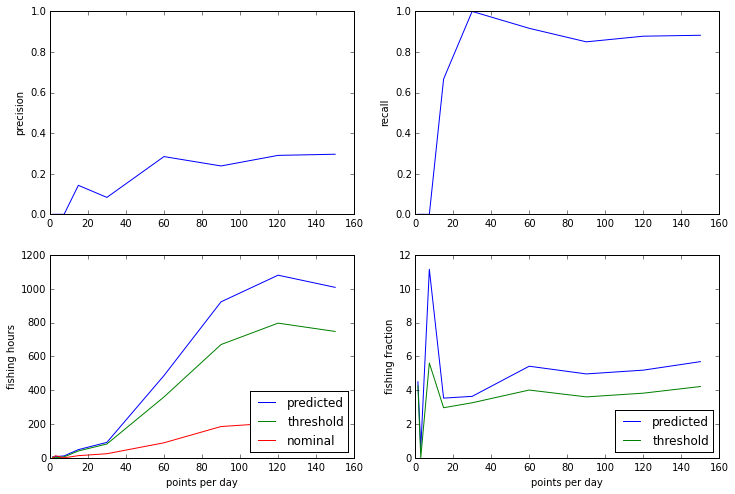

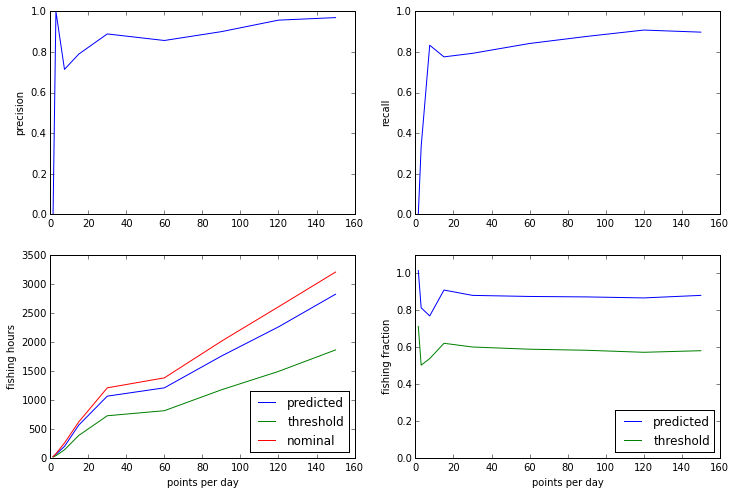

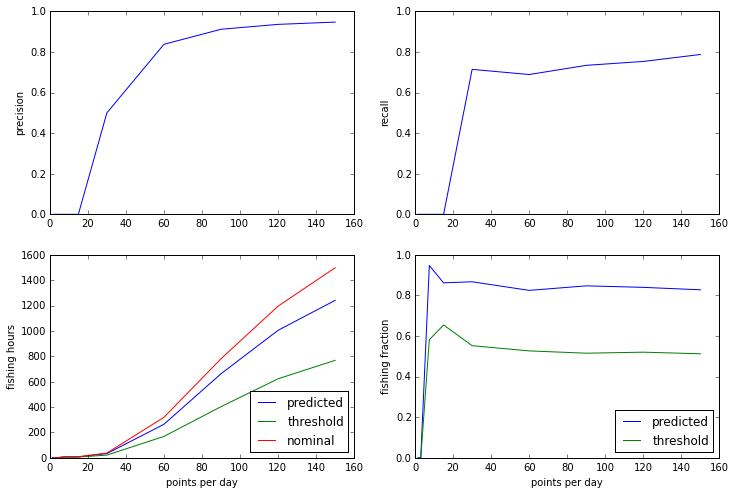

In [11]:
for gear, ylim in [('purse_seine', 20), ('trawler', 2), ('longliner', 2)]:

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    bins = [(100 * alpha, 200 * alpha) for alpha in keep_probs]
        
    mdl = make_model()
    train_model_on_data(mdl, train_data[gear])
    
    td = test_data[gear]
    raw = mdl.predict_proba(td)[:,1]
        
    def bin_data(raw, td):
        bin_centers = []
        recall = []
        prec = []
        predicted_fp = []
        nominal_fp = []
        threshold_fp = []
        counts = td['measure_count_86400']
        
        for start, stop in bins:
            mask = (counts >= start) & (counts < stop)
            bin_centers.append(0.5 * (start + stop))
            predicted, threshold, nominal = _fishing_hours_per_mmsi(
                    td, raw, mask=mask, max_gap=24)

            predicted_fp.append(predicted)
            nominal_fp.append(nominal)
            threshold_fp.append(threshold)
            actual = td['classification'][mask] > 0.5
            recall.append(metrics.recall_score(actual, raw[mask] > 0.5))
            prec.append(metrics.precision_score(actual, raw[mask] > 0.5))
        return recall, prec, bin_centers, np.array(predicted_fp), np.array(nominal_fp), np.array(threshold_fp)
    
    
    recall, prec, ppd, pred_hours, nom_hours, thresh_hours = bin_data(raw, td)

    plt.figure(figsize=(12,8))
    
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
    
    ax1.plot(ppd, prec)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("precision")

    ax2.plot(ppd, recall)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("recall")
    
    ax3.plot(ppd, pred_hours, label="predicted")
    ax3.plot(ppd, thresh_hours, label="threshold")
    ax3.plot(ppd, nom_hours, label="nominal")
    ax3.set_xlabel("points per day")
    ax3.set_ylabel("fishing hours")
    ax3.set_ylim(0, None)
    ax3.legend(loc=4)

    ax4.plot(ppd, np.array(pred_hours, dtype=float) / (nom_hours + 1), label="predicted")
    ax4.plot(ppd, np.array(thresh_hours, dtype=float) / (nom_hours + 1), label="threshold")
    ax4.set_xlabel("points per day")
    ax4.set_ylabel("fishing fraction")
    ax4.set_ylim(0, None)
    ax4.legend(loc=4)
    
    plt.show()